# Automatically Feature Engeneering Sendy challenge 

# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from IPython.display import display,HTML
import pandas_profiling
import numpy as np
import missingno as msno
# from dython.nominal import associations
from scipy.stats import norm, boxcox,skew
from geopy import distance
%matplotlib inline

In [2]:
import featuretools as ft

In [3]:
#model imports
from sklearn.linear_model import HuberRegressor,SGDRegressor,ElasticNet, Ridge,LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor,GradientBoostingRegressor
from xgboost.sklearn import XGBRegressor
from lightgbm.sklearn import LGBMRegressor
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

In [114]:
pd.set_option('display.max_columns', 92)
pd.set_option('display.width', 4)
pd.set_option('display.max_rows', 300)
sns.set(rc={'figure.figsize':(10,6)})

# Data load

In [239]:
data = pd.read_csv("../Sendy_Logistics_Challenge/data_sendy/Train.csv")
riders = pd.read_csv("../Sendy_Logistics_Challenge/data_sendy/Riders.csv")
test_zindi = pd.read_csv("../Sendy_Logistics_Challenge/data_sendy/Test.csv")
submission = pd.read_csv("../Sendy_Logistics_Challenge/data_sendy/SampleSubmission.csv")
vardef = pd.read_csv('../Sendy_Logistics_Challenge/data_sendy/VariableDefinitions.csv')

In [295]:
data

,Order No,Platform Type,Personal or Business,Pickup - Day of Month,Pickup - Weekday (Mo = 1),Distance (KM),Temperature,Rider Id,t_from_pl_to_conf_1_2,t_from_conf_to_arrival_2_3,t_from_arrival_to_pickup_3_4,time_interval_1_3,time_interval_2_4,time_interval_1_4,Pickup - hour,is_holiday
0,Order_No_4211,3,Business,9,5,4,20.400000,Rider_Id_432,264.0,1477.0,1363.0,1741.0,2840.0,3104.0,10,0
1,Order_No_25375,3,Personal,12,5,16,26.400000,Rider_Id_856,425.0,1021.0,227.0,1446.0,1248.0,1673.0,11,0
2,Order_No_1899,3,Business,30,2,3,23.258889,Rider_Id_155,199.0,410.0,209.0,609.0,619.0,818.0,12,0
3,Order_No_9336,3,Business,15,5,9,19.200000,Rider_Id_855,31.0,711.0,310.0,742.0,1021.0,1052.0,9,0
4,Order_No_27883,1,Personal,13,1,9,15.400000,Rider_Id_770,60.0,455.0,90.0,515.0,545.0,605.0,10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21196,Order_No_8834,3,Personal,20,3,3,28.600000,Rider_Id_953,31.0,220.0,1279.0,251.0,1499.0,1530.0,16,0
21197,Order_No_22892,3,Business,13,6,7,26.000000,Rider_Id_155,7.0,383.0,803.0,390.0,1186.0,1193.0,10,1
21198,Order_No_2831,3,Business,7,4,20,29.200000,Rider_Id_697,53.0,1388.0,1235.0,1441.0,2623.0,2676.0,17,0
21199,Order_No_6174,1,Personal,4,3,13,15.000000,Rider_Id_347,14.0,426.0,376.0,440.0,802.0,816.0,9,0


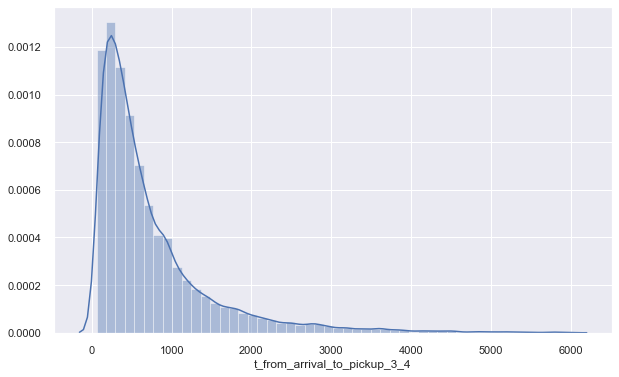

In [296]:
sns.distplot(data.t_from_arrival_to_pickup_3_4)

# Обработка времени и температуры

In [240]:
def add_time_feature(data):
    # через сколько гонщик подтвердил, что он приедет за заказом
    data['t_from_pl_to_conf_1_2'] = (pd.to_datetime(data["Confirmation - Time"]) - pd.to_datetime(data["Placement - Time"])).astype('timedelta64[s]')
    # через сколько времени после подтверждения гонщик приехал, чтобы забрать заказ
    data['t_from_conf_to_arrival_2_3'] = (pd.to_datetime(data["Arrival at Pickup - Time"]) - pd.to_datetime(data["Confirmation - Time"])).astype('timedelta64[s]')
    # промежуток времени между  тем когда гонщик приехал забрать и заказ, и чеез сколько он его реально забрал
    data['t_from_arrival_to_pickup_3_4'] = (pd.to_datetime(data["Pickup - Time"]) - pd.to_datetime(data["Arrival at Pickup - Time"])).astype('timedelta64[s]')
    
    #Суммы по промежуткам времени
    
    # сколько времени прошло между размещением заказа и временем его приезда за заказом
    data['time_interval_1_3'] = data['t_from_pl_to_conf_1_2'] + data['t_from_conf_to_arrival_2_3']
    
    # сколько времени прошло между подтверждением заказа и временем,когда он забрал заказ
    data['time_interval_2_4'] = data['t_from_conf_to_arrival_2_3'] + data['t_from_arrival_to_pickup_3_4']
    
    # сколько времени прошло между размещением заказа и временем,когда он забрал заказ
    data['time_interval_1_4'] = data['t_from_pl_to_conf_1_2']+data['t_from_conf_to_arrival_2_3']+data['t_from_arrival_to_pickup_3_4']
    
    
    
    data["Pickup - hour"] = pd.to_datetime(data["Pickup - Time"]).dt.hour.astype("category")
    # является ли выходным
    data['is_holiday'] = np.where(data['Pickup - Weekday (Mo = 1)'] >=6,1,0)

In [241]:
add_time_feature(data)
add_time_feature(test_zindi)

In [242]:
# fill temperature with mean
mean_temp = data.Temperature.mean()
data.Temperature.fillna(value=mean_temp,inplace=True)
test_zindi.Temperature.fillna(value=mean_temp,inplace=True)

In [243]:
columns_to_drop_both = ['Vehicle Type','User Id','Precipitation in millimeters','Pickup Lat','Pickup Long',
                        'Destination Lat','Destination Long',
                       'Placement - Day of Month',
                       'Placement - Weekday (Mo = 1)',
                       'Placement - Time', 'Confirmation - Day of Month',
                       'Confirmation - Weekday (Mo = 1)',
                       'Confirmation - Time',
                        "Pickup - Time",
                       'Arrival at Pickup - Day of Month',
                       'Arrival at Pickup - Weekday (Mo = 1)',
                       'Arrival at Pickup - Time']
columns_to_drop_train = ['Arrival at Destination - Day of Month',
        'Arrival at Destination - Weekday (Mo = 1)',
       'Arrival at Destination - Time']
data.drop(columns=columns_to_drop_both + columns_to_drop_train,inplace=True)
test_zindi.drop(columns=columns_to_drop_both,inplace=True)

In [244]:
# target = data[['Order No','Time from Pickup to Arrival']].copy()
# data.drop('Time from Pickup to Arrival',axis=1,inplace = True)

In [245]:
assert data.shape[1] - 1 == test_zindi.shape[1], 'ШО???'

In [246]:
# x = data[data['Order No'] == 'Order_No_2800'].copy()
# x

## riders

In [247]:
data['speed'] = data['Distance (KM)'] / (data['Time from Pickup to Arrival'] / 3600) 

In [248]:
data['is_anomaly'] = np.where(data['speed'] >=60,1,0)

In [249]:
data_noano = data[data.speed <=60].copy()
data_noano = data_noano.rename(columns = {'speed':'noano_speed'})

In [250]:
max_noano_speed_to_merge = pd.DataFrame(data_noano.groupby('Rider Id').max().noano_speed).rename(columns = {'noano_speed':'max_noano_speed'})
min_noano_speed_to_merge = pd.DataFrame(data_noano.groupby('Rider Id').min().noano_speed).rename(columns = {'noano_speed':'min_noano_speed'})
mean_noano_speed_to_merge = pd.DataFrame(data_noano.groupby('Rider Id').mean().noano_speed).rename(columns = {'noano_speed':'mean_noano_speed'})
std_noano_speed_to_merge = pd.DataFrame(data_noano.groupby('Rider Id').std().noano_speed).rename(columns = {'noano_speed':'std_noano_speed'})
max_speed_to_merge = pd.DataFrame(data.groupby('Rider Id').max().speed).rename(columns = {'speed':'max_speed'})
min_speed_to_merge = pd.DataFrame(data.groupby('Rider Id').min().speed).rename(columns = {'speed':'min_speed'})
mean_speed_to_merge = pd.DataFrame(data.groupby('Rider Id').mean().speed).rename(columns = {'speed':'mean_speed'})
std_speed_to_merge = pd.DataFrame(data.groupby('Rider Id').std().speed).rename(columns = {'speed':'std_speed'})


speed_stat = pd.concat([max_speed_to_merge, min_speed_to_merge,mean_speed_to_merge,std_speed_to_merge], axis=1,sort=True)
noano_speed_stat = pd.concat([max_noano_speed_to_merge, min_noano_speed_to_merge,mean_noano_speed_to_merge,std_noano_speed_to_merge], axis=1,sort=True)
full_stat = pd.concat([speed_stat,noano_speed_stat],axis = 1,sort=True)

In [251]:
# были ли аномальные значения
result = pd.concat([riders.set_index('Rider Id'), full_stat], axis=1,sort=True)
result['has_anomaly'] = np.where(result.max_speed >=60,1,0)

In [252]:
result.reset_index(inplace=True)
result.rename(columns={'index':'Rider Id'},inplace=True)

In [253]:
result.head(5)


,Rider Id,No_Of_Orders,Age,Average_Rating,No_of_Ratings,max_speed,min_speed,mean_speed,std_speed,max_noano_speed,min_noano_speed,mean_noano_speed,std_noano_speed,has_anomaly
0,Rider_Id_0,3048,2570,14.0,512,31.012204,31.012204,31.012204,NaN,31.012204,31.012204,31.012204,NaN,0
1,Rider_Id_1,8,589,0.0,1,29.707427,29.707427,29.707427,NaN,29.707427,29.707427,29.707427,NaN,0
2,Rider_Id_10,6978,1990,13.3,413,36000.000000,15.197889,5927.247261,7689.150919,38.135593,15.197889,28.033570,5.737331,1
3,Rider_Id_100,362,910,13.4,109,56.509695,3.922637,24.586292,9.654220,56.509695,3.922637,24.586292,9.654220,0
4,Rider_Id_101,1299,986,13.1,287,240.000000,4.845222,25.133049,18.525649,54.609102,4.845222,23.952462,9.414009,1


In [176]:
#заполнение медиаой  пропущенных значений
def median_fillna(dataset):
    df = pd.DataFrame(dataset.isna().sum()) 
    df = df.rename(columns={0: 'na_count'})
    column_with_na = list(df[df.na_count != 0].reset_index()['index'].values)
    
    for i in column_with_na:
        dataset[i]= dataset[i].fillna(dataset[i].median())

In [254]:
#заполнение медиаой  пропущенных значений
def mean_fillna(dataset):
    df = pd.DataFrame(dataset.isna().sum()) 
    df = df.rename(columns={0: 'na_count'})
    column_with_na = list(df[df.na_count != 0].reset_index()['index'].values)
    
    for i in column_with_na:
        dataset[i]= dataset[i].fillna(dataset[i].mean())

In [255]:
#заполенение пропусков либо средним либо медианой
mean_fillna(result)
# median_fillna(result)

In [256]:
assert data.shape[1]-3 == test_zindi.shape[1], 'ШО??'

In [257]:
# result['rider_avg_rate_2_noRate'] = result['Average_Rating'] / (result['No_of_Ratings']+1)
# result['rider_prod'] = result['No_Of_Orders'] / (result['Age']+1)

# result['rider_rate_inday'] = result['No_of_Ratings'] / (result['Age']+1)

# result['rider_rate_inday'] = result['No_of_Ratings'] / (result['No_Of_Orders'])

# Using FeatureTools

In [187]:
# удаление аномальных значений
# data_withot_bad_speed = data[data.speed <=60].copy()

In [258]:
# удаление аномальных значений
# # Дропнем таргет
# target_withot_bad_speed = data_withot_bad_speed[['Order No','Time from Pickup to Arrival']].copy()
# speed_withot_bad_speed = data_withot_bad_speed[['Order No','speed']].copy()
# is_anomaly_withot_bad_speed = data_withot_bad_speed[['Order No','is_anomaly']].copy()

# data_withot_bad_speed.drop('Time from Pickup to Arrival',axis=1,inplace = True)
# data_withot_bad_speed.drop('speed',axis=1,inplace = True)
# data_withot_bad_speed.drop('is_anomaly',axis=1,inplace = True)

In [259]:
# Дропнем таргет
target = data[['Order No','Time from Pickup to Arrival']].copy()
speed = data[['Order No','speed']].copy()
is_anomaly = data[['Order No','is_anomaly']].copy()

data.drop('Time from Pickup to Arrival',axis=1,inplace = True)
data.drop('speed',axis=1,inplace = True)
data.drop('is_anomaly',axis=1,inplace = True)

In [260]:
assert data.shape[1] == test_zindi.shape[1], 'ШО????'

In [262]:
# assert data_withot_bad_speed.shape[1] == test_zindi.shape[1], 'ШО????'

In [263]:
def get_feature_matrix(dataset_1,dataset_2 = result):
    es = ft.EntitySet(id = 'Orders')

    es = es.entity_from_dataframe(entity_id='data',
                                   dataframe=dataset_1,
                                  index="Order No",
                                 variable_types={"Platform Type": ft.variable_types.Categorical,
                                               "Personal or Business": ft.variable_types.Categorical,
                                                'Pickup - Weekday (Mo = 1)':ft.variable_types.Categorical,
                                                'Pickup - Day of Month': ft.variable_types.Categorical,
                                                'Rider Id': ft.variable_types.Categorical})
    es = es.entity_from_dataframe(entity_id="drivers",
                                   dataframe=dataset_2,
                                   index="Rider Id",
                                    variable_types={
                                   'Rider Id': ft.variable_types.Categorical,
                                   'Average_Rating' : ft.variable_types.Categorical})

    new_relationship = ft.Relationship(es["drivers"]["Rider Id"],
                                        es["data"]["Rider Id"])


    es = es.add_relationship(new_relationship)
    
    feature_matrix_data, feature_defs_data = ft.dfs(entityset=es,
                              target_entity="data")
    
    return feature_matrix_data, feature_defs_data
    

In [264]:
feature_matrix_data_train, feature_defs_data_train = get_feature_matrix(data)
feature_matrix_data_test, feature_defs_data_test = get_feature_matrix(test_zindi)


assert feature_matrix_data_train.shape[1] == feature_matrix_data_test.shape[1], 'ШО'

In [196]:
# tr_feature_matrix_data_train, tr_feature_defs_data_train = get_feature_matrix(data_withot_bad_speed)

In [265]:
feature_matrix_data_train.shape[1], feature_matrix_data_test.shape[1]

(93, 93)

In [198]:
# median_fillna(tr_feature_matrix_data_train)


In [266]:
#заполним пропуски медианой или средним
mean_fillna(feature_matrix_data_train)
mean_fillna(feature_matrix_data_test)


# median_fillna(feature_matrix_data_train)
# median_fillna(feature_matrix_data_test)


assert feature_matrix_data_train.isna().sum().sum() == feature_matrix_data_test.isna().sum().sum(), 'ШО'

In [267]:
# feature_matrix_data_train = pd.concat([feature_matrix_data_train,target.set_index('Order No')],axis=1)

# Обучимся

In [268]:
y = target['Time from Pickup to Arrival']
X = feature_matrix_data_train
# test_zindi = test_zindi.drop(['Rider Id'],axis=1)

In [269]:
for c in X.columns:
    col_type = X[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        X[c] = X[c].astype('category')
        


In [270]:
for c in feature_matrix_data_test.columns:
    col_type = feature_matrix_data_test[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        feature_matrix_data_test[c] = feature_matrix_data_test[c].astype('category')

In [271]:
from sklearn.model_selection import train_test_split, KFold,cross_val_score

train_x,val_x,train_y,val_y = train_test_split(X,y,test_size=0.3,random_state = 42)

In [272]:
def rmsle_cv(model,train,y_train,n_folds=5):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(np.mean(rmse))

In [273]:
def rmse(y_true,y_preds,extras=None):
    return np.sqrt(mean_squared_error(y_true,y_preds))

In [274]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'max_depth': 6, 
    'learning_rate': 0.05,
    'verbose': 0, 
    'early_stopping_round': 30,
    'feature_name': 'auto', 
    'categorical_feature': ['Pickup - hour','Personal or Business','Rider Id','drivers.MODE(data.Personal or Business']}
n_estimators = 1000

In [275]:
categorical_feats =  ['Pickup - hour','Personal or Business','Rider Id','drivers.MODE(data.Personal or Business)',]
n_iters = 10
preds_buf = []
err_buf = []
for i in range(n_iters): 
    x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.30, random_state=i)
    d_train = lgb.Dataset(x_train, label=y_train,categorical_feature=categorical_feats)
    d_valid = lgb.Dataset(x_valid, label=y_valid,categorical_feature=categorical_feats)
    watchlist = [d_valid]

    model = lgb.train(params, d_train, n_estimators, watchlist, verbose_eval=1)
    
    preds = model.predict(x_valid)
    
    err = rmse(y_valid, preds)
    err_buf.append(err)
    print('RMSLE = ' + str(err))
    
    
    preds = model.predict(feature_matrix_data_test)
    preds_buf.append(preds)

print('Mean RMSE = ' + str(np.mean(err_buf)) + ' +/- ' + str(np.std(err_buf)))

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:794: UserWarning: feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.
  .format(key))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:794: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  .format(key))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:814: UserWarnin

[1]	valid_0's rmse: 966.187
Training until validation scores don't improve for 30 rounds
[2]	valid_0's rmse: 948.533
[3]	valid_0's rmse: 932.307
[4]	valid_0's rmse: 917.522
[5]	valid_0's rmse: 903.697
[6]	valid_0's rmse: 891.132
[7]	valid_0's rmse: 879.337
[8]	valid_0's rmse: 868.069
[9]	valid_0's rmse: 858.144
[10]	valid_0's rmse: 848.834
[11]	valid_0's rmse: 840.234
[12]	valid_0's rmse: 832.518
[13]	valid_0's rmse: 825.423
[14]	valid_0's rmse: 818.706
[15]	valid_0's rmse: 812.668
[16]	valid_0's rmse: 807.041
[17]	valid_0's rmse: 802.002
[18]	valid_0's rmse: 797.241
[19]	valid_0's rmse: 793.124
[20]	valid_0's rmse: 788.86
[21]	valid_0's rmse: 785.172
[22]	valid_0's rmse: 782.088
[23]	valid_0's rmse: 778.906
[24]	valid_0's rmse: 776.11
[25]	valid_0's rmse: 773.502
[26]	valid_0's rmse: 770.798
[27]	valid_0's rmse: 768.688
[28]	valid_0's rmse: 766.569
[29]	valid_0's rmse: 764.537
[30]	valid_0's rmse: 762.772
[31]	valid_0's rmse: 761.165
[32]	valid_0's rmse: 759.828
[33]	valid_0's rmse: 7

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:794: UserWarning: feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.
  .format(key))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:794: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  .format(key))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:814: UserWarnin

[1]	valid_0's rmse: 958.194
Training until validation scores don't improve for 30 rounds
[2]	valid_0's rmse: 939.954
[3]	valid_0's rmse: 923.362
[4]	valid_0's rmse: 908.048
[5]	valid_0's rmse: 894.165
[6]	valid_0's rmse: 881.037
[7]	valid_0's rmse: 869.083
[8]	valid_0's rmse: 857.852
[9]	valid_0's rmse: 847.486
[10]	valid_0's rmse: 837.961
[11]	valid_0's rmse: 829
[12]	valid_0's rmse: 820.695
[13]	valid_0's rmse: 813.461
[14]	valid_0's rmse: 806.61
[15]	valid_0's rmse: 800.358
[16]	valid_0's rmse: 794.764
[17]	valid_0's rmse: 789.461
[18]	valid_0's rmse: 784.502
[19]	valid_0's rmse: 779.776
[20]	valid_0's rmse: 775.428
[21]	valid_0's rmse: 771.402
[22]	valid_0's rmse: 768.001
[23]	valid_0's rmse: 765.05
[24]	valid_0's rmse: 761.887
[25]	valid_0's rmse: 759.131
[26]	valid_0's rmse: 756.67
[27]	valid_0's rmse: 754.327
[28]	valid_0's rmse: 752.286
[29]	valid_0's rmse: 750.418
[30]	valid_0's rmse: 748.585
[31]	valid_0's rmse: 747.058
[32]	valid_0's rmse: 745.562
[33]	valid_0's rmse: 744.40

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:794: UserWarning: feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.
  .format(key))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:794: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  .format(key))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:814: UserWarnin

[1]	valid_0's rmse: 953.063
Training until validation scores don't improve for 30 rounds
[2]	valid_0's rmse: 934.417
[3]	valid_0's rmse: 917.348
[4]	valid_0's rmse: 901.888
[5]	valid_0's rmse: 887.494
[6]	valid_0's rmse: 874.368
[7]	valid_0's rmse: 862.255
[8]	valid_0's rmse: 850.944
[9]	valid_0's rmse: 840.632
[10]	valid_0's rmse: 831.179
[11]	valid_0's rmse: 822.69
[12]	valid_0's rmse: 814.567
[13]	valid_0's rmse: 807.641
[14]	valid_0's rmse: 801.192
[15]	valid_0's rmse: 794.857
[16]	valid_0's rmse: 789.139
[17]	valid_0's rmse: 783.725
[18]	valid_0's rmse: 778.838
[19]	valid_0's rmse: 774.331
[20]	valid_0's rmse: 769.909
[21]	valid_0's rmse: 766.239
[22]	valid_0's rmse: 762.902
[23]	valid_0's rmse: 759.605
[24]	valid_0's rmse: 756.775
[25]	valid_0's rmse: 753.938
[26]	valid_0's rmse: 751.578
[27]	valid_0's rmse: 749.445
[28]	valid_0's rmse: 747.422
[29]	valid_0's rmse: 745.606
[30]	valid_0's rmse: 744.077
[31]	valid_0's rmse: 742.7
[32]	valid_0's rmse: 741.241
[33]	valid_0's rmse: 73

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:794: UserWarning: feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.
  .format(key))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:794: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  .format(key))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:814: UserWarnin

[1]	valid_0's rmse: 957.779
Training until validation scores don't improve for 30 rounds
[2]	valid_0's rmse: 939.813
[3]	valid_0's rmse: 923.093
[4]	valid_0's rmse: 907.824
[5]	valid_0's rmse: 893.899
[6]	valid_0's rmse: 881.239
[7]	valid_0's rmse: 869.083
[8]	valid_0's rmse: 858.05
[9]	valid_0's rmse: 847.753
[10]	valid_0's rmse: 838.395
[11]	valid_0's rmse: 829.739
[12]	valid_0's rmse: 821.691
[13]	valid_0's rmse: 814.361
[14]	valid_0's rmse: 807.661
[15]	valid_0's rmse: 801.362
[16]	valid_0's rmse: 795.666
[17]	valid_0's rmse: 790.425
[18]	valid_0's rmse: 785.837
[19]	valid_0's rmse: 781.436
[20]	valid_0's rmse: 777.201
[21]	valid_0's rmse: 773.11
[22]	valid_0's rmse: 769.885
[23]	valid_0's rmse: 766.654
[24]	valid_0's rmse: 763.757
[25]	valid_0's rmse: 760.994
[26]	valid_0's rmse: 758.858
[27]	valid_0's rmse: 756.343
[28]	valid_0's rmse: 754.276
[29]	valid_0's rmse: 752.223
[30]	valid_0's rmse: 750.365
[31]	valid_0's rmse: 748.786
[32]	valid_0's rmse: 747.265
[33]	valid_0's rmse: 7

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:794: UserWarning: feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.
  .format(key))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:794: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  .format(key))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:814: UserWarnin

[1]	valid_0's rmse: 982.68
Training until validation scores don't improve for 30 rounds
[2]	valid_0's rmse: 964.483
[3]	valid_0's rmse: 947.632
[4]	valid_0's rmse: 931.905
[5]	valid_0's rmse: 917.54
[6]	valid_0's rmse: 904.413
[7]	valid_0's rmse: 892.107
[8]	valid_0's rmse: 881.07
[9]	valid_0's rmse: 870.813
[10]	valid_0's rmse: 861.501
[11]	valid_0's rmse: 852.995
[12]	valid_0's rmse: 845.095
[13]	valid_0's rmse: 837.448
[14]	valid_0's rmse: 830.826
[15]	valid_0's rmse: 824.395
[16]	valid_0's rmse: 818.579
[17]	valid_0's rmse: 813.492
[18]	valid_0's rmse: 808.507
[19]	valid_0's rmse: 804.057
[20]	valid_0's rmse: 799.898
[21]	valid_0's rmse: 795.948
[22]	valid_0's rmse: 792.564
[23]	valid_0's rmse: 789.071
[24]	valid_0's rmse: 786.078
[25]	valid_0's rmse: 783.134
[26]	valid_0's rmse: 780.503
[27]	valid_0's rmse: 778.185
[28]	valid_0's rmse: 776.058
[29]	valid_0's rmse: 774.069
[30]	valid_0's rmse: 772.1
[31]	valid_0's rmse: 770.41
[32]	valid_0's rmse: 768.634
[33]	valid_0's rmse: 767.0

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:794: UserWarning: feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.
  .format(key))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:794: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  .format(key))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:814: UserWarnin

[1]	valid_0's rmse: 978.174
Training until validation scores don't improve for 30 rounds
[2]	valid_0's rmse: 959.936
[3]	valid_0's rmse: 942.975
[4]	valid_0's rmse: 927.576
[5]	valid_0's rmse: 913.61
[6]	valid_0's rmse: 900.129
[7]	valid_0's rmse: 887.855
[8]	valid_0's rmse: 876.284
[9]	valid_0's rmse: 866.031
[10]	valid_0's rmse: 856.274
[11]	valid_0's rmse: 847.164
[12]	valid_0's rmse: 839.027
[13]	valid_0's rmse: 831.377
[14]	valid_0's rmse: 824.343
[15]	valid_0's rmse: 817.952
[16]	valid_0's rmse: 812.169
[17]	valid_0's rmse: 806.451
[18]	valid_0's rmse: 801.338
[19]	valid_0's rmse: 796.801
[20]	valid_0's rmse: 792.551
[21]	valid_0's rmse: 788.677
[22]	valid_0's rmse: 785.085
[23]	valid_0's rmse: 781.558
[24]	valid_0's rmse: 778.187
[25]	valid_0's rmse: 775.289
[26]	valid_0's rmse: 772.398
[27]	valid_0's rmse: 769.917
[28]	valid_0's rmse: 767.889
[29]	valid_0's rmse: 765.725
[30]	valid_0's rmse: 763.946
[31]	valid_0's rmse: 762.031
[32]	valid_0's rmse: 760.406
[33]	valid_0's rmse: 

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:794: UserWarning: feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.
  .format(key))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:794: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  .format(key))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:814: UserWarnin

[1]	valid_0's rmse: 964.181
Training until validation scores don't improve for 30 rounds
[2]	valid_0's rmse: 945.471
[3]	valid_0's rmse: 928.357
[4]	valid_0's rmse: 912.67
[5]	valid_0's rmse: 898.091
[6]	valid_0's rmse: 884.957
[7]	valid_0's rmse: 872.387
[8]	valid_0's rmse: 861.045
[9]	valid_0's rmse: 850.309
[10]	valid_0's rmse: 840.27
[11]	valid_0's rmse: 831.082
[12]	valid_0's rmse: 823.069
[13]	valid_0's rmse: 815.321
[14]	valid_0's rmse: 808.487
[15]	valid_0's rmse: 801.919
[16]	valid_0's rmse: 795.824
[17]	valid_0's rmse: 790.196
[18]	valid_0's rmse: 785.228
[19]	valid_0's rmse: 780.712
[20]	valid_0's rmse: 776.13
[21]	valid_0's rmse: 772.296
[22]	valid_0's rmse: 768.543
[23]	valid_0's rmse: 765.376
[24]	valid_0's rmse: 762.335
[25]	valid_0's rmse: 759.433
[26]	valid_0's rmse: 756.973
[27]	valid_0's rmse: 754.603
[28]	valid_0's rmse: 752.367
[29]	valid_0's rmse: 750.414
[30]	valid_0's rmse: 748.664
[31]	valid_0's rmse: 746.939
[32]	valid_0's rmse: 745.463
[33]	valid_0's rmse: 74

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:794: UserWarning: feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.
  .format(key))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:794: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  .format(key))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:814: UserWarnin

[1]	valid_0's rmse: 977.661
Training until validation scores don't improve for 30 rounds
[2]	valid_0's rmse: 959.604
[3]	valid_0's rmse: 943.224
[4]	valid_0's rmse: 927.668
[5]	valid_0's rmse: 913.636
[6]	valid_0's rmse: 900.788
[7]	valid_0's rmse: 888.852
[8]	valid_0's rmse: 877.396
[9]	valid_0's rmse: 867.09
[10]	valid_0's rmse: 857.525
[11]	valid_0's rmse: 848.646
[12]	valid_0's rmse: 840.609
[13]	valid_0's rmse: 833.3
[14]	valid_0's rmse: 826.378
[15]	valid_0's rmse: 819.975
[16]	valid_0's rmse: 814.079
[17]	valid_0's rmse: 808.921
[18]	valid_0's rmse: 803.81
[19]	valid_0's rmse: 799.187
[20]	valid_0's rmse: 794.662
[21]	valid_0's rmse: 790.967
[22]	valid_0's rmse: 787.22
[23]	valid_0's rmse: 783.6
[24]	valid_0's rmse: 780.635
[25]	valid_0's rmse: 777.833
[26]	valid_0's rmse: 775.316
[27]	valid_0's rmse: 772.95
[28]	valid_0's rmse: 770.88
[29]	valid_0's rmse: 769.029
[30]	valid_0's rmse: 766.93
[31]	valid_0's rmse: 765.363
[32]	valid_0's rmse: 763.935
[33]	valid_0's rmse: 762.575
[

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:794: UserWarning: feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.
  .format(key))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:794: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  .format(key))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:814: UserWarnin

[1]	valid_0's rmse: 980.77
Training until validation scores don't improve for 30 rounds
[2]	valid_0's rmse: 962.896
[3]	valid_0's rmse: 946.367
[4]	valid_0's rmse: 931.121
[5]	valid_0's rmse: 916.966
[6]	valid_0's rmse: 904.175
[7]	valid_0's rmse: 892.269
[8]	valid_0's rmse: 881.287
[9]	valid_0's rmse: 871.191
[10]	valid_0's rmse: 861.872
[11]	valid_0's rmse: 853.124
[12]	valid_0's rmse: 844.983
[13]	valid_0's rmse: 837.474
[14]	valid_0's rmse: 830.728
[15]	valid_0's rmse: 824.527
[16]	valid_0's rmse: 818.815
[17]	valid_0's rmse: 813.757
[18]	valid_0's rmse: 808.66
[19]	valid_0's rmse: 804.006
[20]	valid_0's rmse: 799.759
[21]	valid_0's rmse: 796.158
[22]	valid_0's rmse: 792.697
[23]	valid_0's rmse: 789.309
[24]	valid_0's rmse: 786.393
[25]	valid_0's rmse: 783.473
[26]	valid_0's rmse: 780.96
[27]	valid_0's rmse: 778.636
[28]	valid_0's rmse: 776.612
[29]	valid_0's rmse: 774.647
[30]	valid_0's rmse: 772.815
[31]	valid_0's rmse: 771.254
[32]	valid_0's rmse: 769.708
[33]	valid_0's rmse: 76

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:794: UserWarning: feature_name keyword has been found in `params` and will be ignored.
Please use feature_name argument of the Dataset constructor to pass this parameter.
  .format(key))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:794: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  .format(key))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:814: UserWarnin

[1]	valid_0's rmse: 989.09
Training until validation scores don't improve for 30 rounds
[2]	valid_0's rmse: 971.045
[3]	valid_0's rmse: 954.331
[4]	valid_0's rmse: 938.777
[5]	valid_0's rmse: 924.846
[6]	valid_0's rmse: 911.912
[7]	valid_0's rmse: 899.668
[8]	valid_0's rmse: 888.751
[9]	valid_0's rmse: 878.39
[10]	valid_0's rmse: 868.761
[11]	valid_0's rmse: 860.114
[12]	valid_0's rmse: 852.065
[13]	valid_0's rmse: 844.654
[14]	valid_0's rmse: 837.957
[15]	valid_0's rmse: 831.61
[16]	valid_0's rmse: 826.021
[17]	valid_0's rmse: 820.855
[18]	valid_0's rmse: 816.127
[19]	valid_0's rmse: 811.758
[20]	valid_0's rmse: 807.813
[21]	valid_0's rmse: 804.139
[22]	valid_0's rmse: 800.453
[23]	valid_0's rmse: 797.208
[24]	valid_0's rmse: 794.341
[25]	valid_0's rmse: 791.529
[26]	valid_0's rmse: 788.972
[27]	valid_0's rmse: 786.636
[28]	valid_0's rmse: 784.806
[29]	valid_0's rmse: 782.95
[30]	valid_0's rmse: 781.278
[31]	valid_0's rmse: 779.577
[32]	valid_0's rmse: 778.442
[33]	valid_0's rmse: 777

In [276]:
err_buf

[740.6119555378455,
 734.3473931945896,
 729.1821719097074,
 734.5482144581,
 753.8717035152897,
 744.2684220094491,
 731.6852896951228,
 749.3042072345028,
 753.3744254549032,
 762.604643675514]

In [224]:
#Сделаем предсказание на тест
preds = np.mean(preds_buf, axis=0)

# Adaboost

In [283]:
X.drop('Personal or Business',axis=1,inplace=True)
feature_matrix_data_test.drop('Personal or Business',axis=1,inplace=True)

In [286]:
X.drop('drivers.MODE(data.Personal or Business)',axis=1,inplace=True)
feature_matrix_data_test.drop('drivers.MODE(data.Personal or Business)',axis=1,inplace=True)

X.drop('Rider Id',axis=1,inplace=True)
feature_matrix_data_test.drop('Rider Id',axis=1,inplace=True)

In [287]:
from sklearn.feature_selection import mutual_info_classif
kepler_mutual_information = mutual_info_classif(X, y)

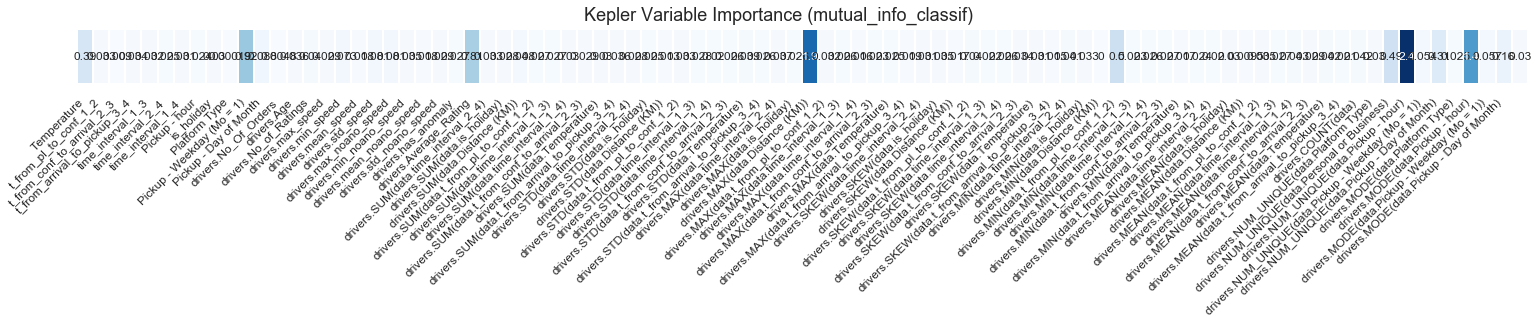

In [288]:
plt.subplots(1, figsize=(26, 1))
sns.heatmap(kepler_mutual_information[:, np.newaxis].T, cmap='Blues', cbar=False, linewidths=1, annot=True)
plt.yticks([], [])
plt.gca().set_xticklabels(X.columns[1:], rotation=45, ha='right', fontsize=12)
plt.suptitle("Kepler Variable Importance (mutual_info_classif)", fontsize=18, y=1.2)
plt.gcf().subplots_adjust(wspace=0.2)
pass

In [289]:
from sklearn.feature_selection import GenericUnivariateSelect

trans = GenericUnivariateSelect(score_func=mutual_info_classif, mode='percentile', param=50)
kepler_X_trans = trans.fit_transform(X, y)

In [291]:
print("We started with {0} features but retained only {1} of them!".format(X.shape[1] - 1, kepler_X_trans.shape[1]))

We started with 89 features but retained only 45 of them!


In [292]:
kepler_X_trans

array([[4, 1477.0, 1363.0, ..., 10, 5, 2],
       [16, 1021.0, 227.0, ..., 15, 1, 14],
       [3, 410.0, 209.0, ..., 9, 2, 10],
       ...,
       [20, 1388.0, 1235.0, ..., 16, 2, 19],
       [13, 426.0, 376.0, ..., 9, 1, 4],
       [12, 268.0, 1046.0, ..., 15, 2, 15]], dtype=object)

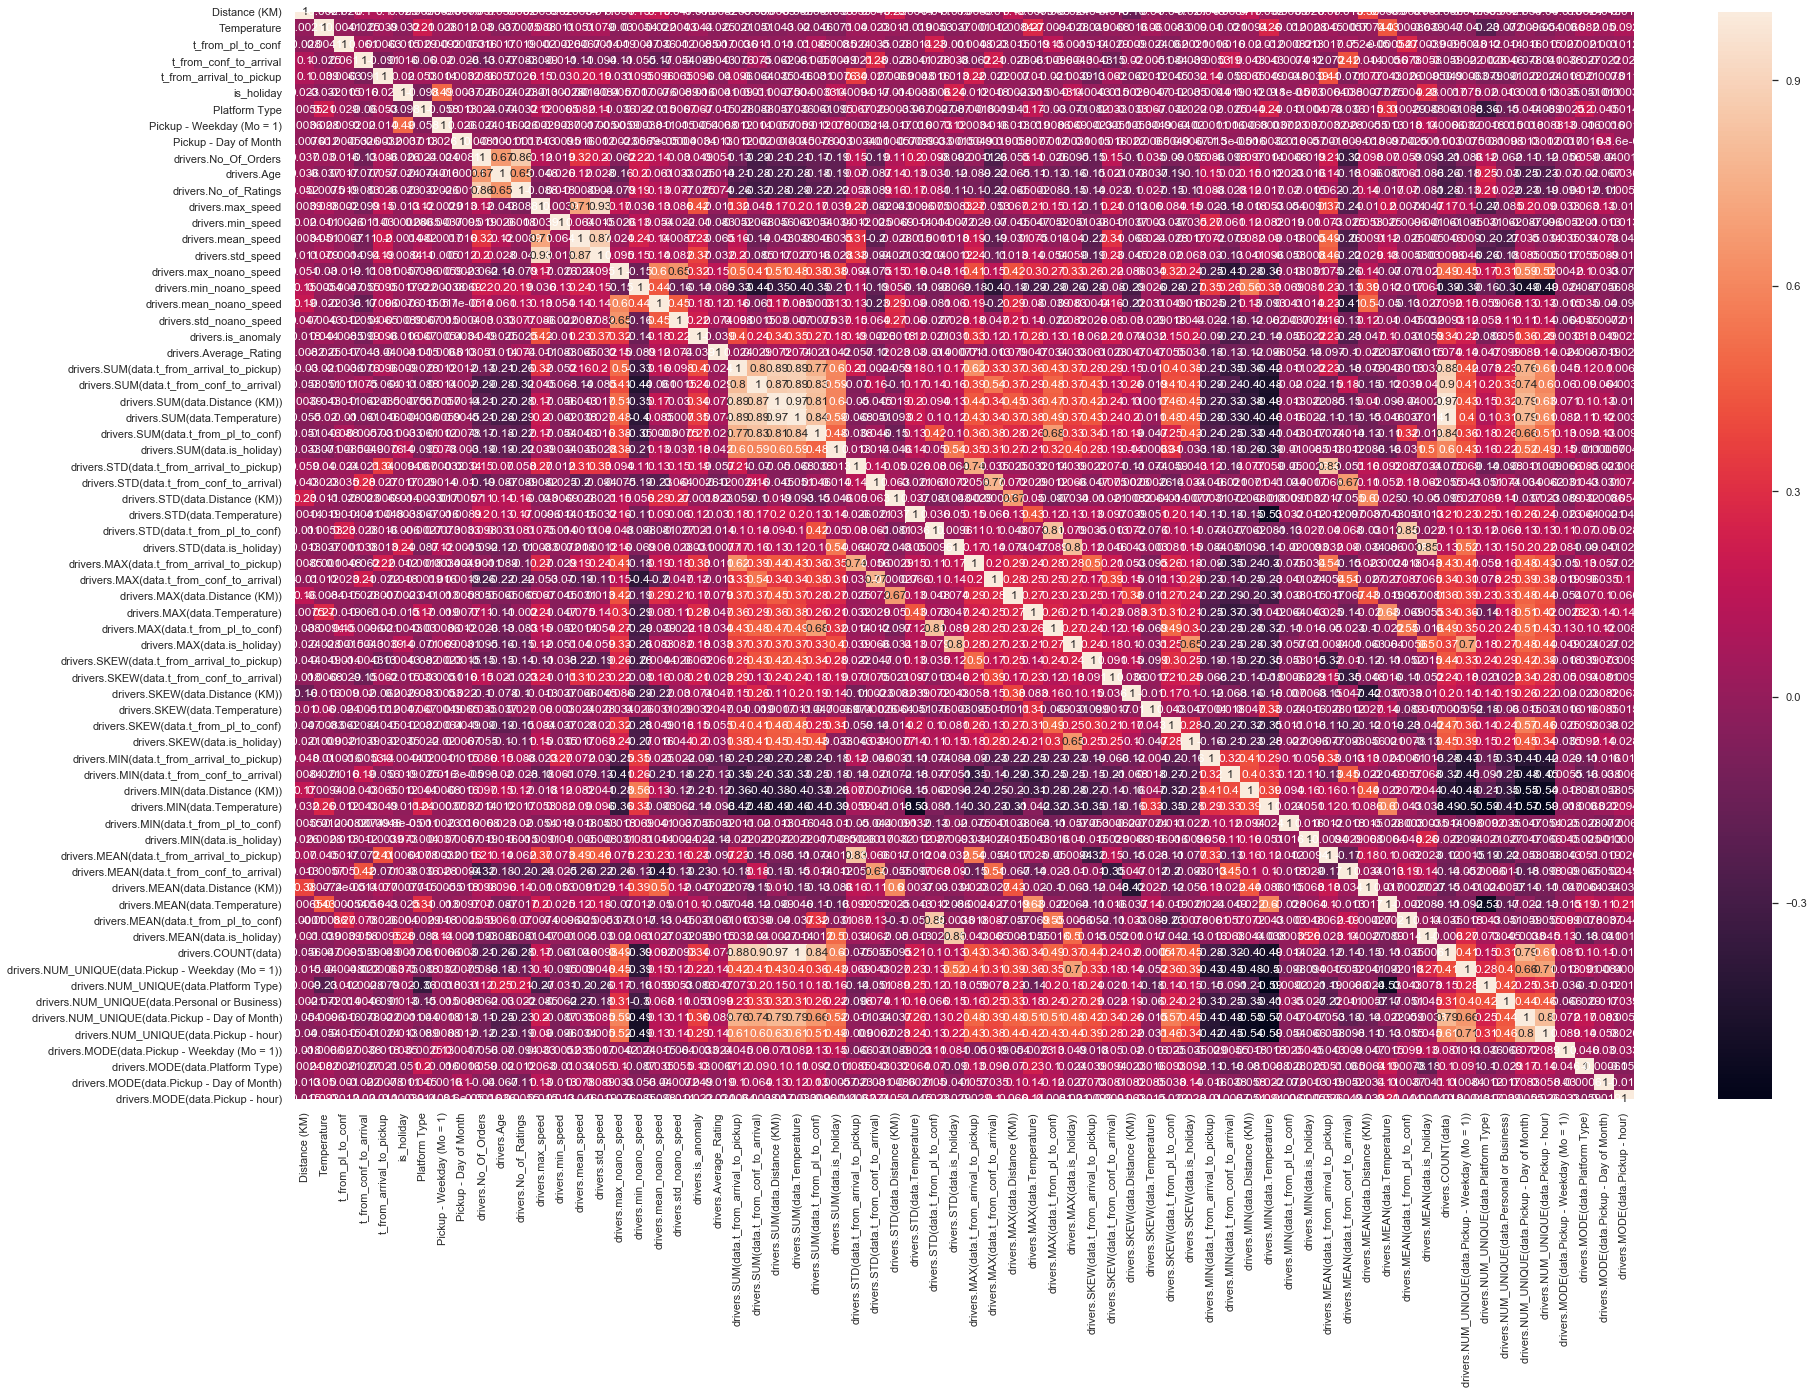

In [251]:
# cor = X.corr()
# plt.figure(figsize=(30,20))
# sns.heatmap(cor,annot=True)


# Other way with StratifiedKFold

In [229]:
from sklearn.model_selection import GridSearchCV,StratifiedKFold

In [231]:
is_anomaly_y= is_anomaly['is_anomaly'] 
is_anomaly_y

0        0
1        0
2        0
3        0
4        0
        ..
21196    1
21197    0
21198    0
21199    0
21200    0
Name: is_anomaly, Length: 21201, dtype: int32

In [232]:
X_str_K_f = X.reset_index().drop('Order No',axis=1)
X_str_K_f.shape

(21201, 93)

In [247]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [248]:
## best parameters found.
lgb_clf = LGBMClassifier(
    objective='binary',
    boosting='gbdt',
    learning_rate = 0.05,
    max_depth = 8,
    num_leaves = 80,
    n_estimators = 400,
    bagging_fraction = 0.8,
    feature_fraction = 0.9)
    #reg_alpha = 0.2,
    #reg_lambda = 0.4)

In [249]:
kf = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
categorical_feats =  ['Pickup - hour','Personal or Business','Rider Id','drivers.MODE(data.Personal or Business)']

preds_dump_pos = []
err_buf= []

for train_index,test_index in kf.split(X,is_anomaly_y):
    print('{} of KFold {}'.format(i,kf.n_splits))
    xtr,xvl = X_str_K_f.loc[train_index],X_str_K_f.loc[test_index]
    ytr,yvl = is_anomaly_y.loc[train_index],is_anomaly_y.loc[test_index]
    
    
    lgb_clf.fit(xtr,ytr)
    
    
    err = roc_auc_score(yvl.values,lgb_clf.predict_proba(xvl)[:, 1])
    err_buf.append(err)
    
    print('ROC AUC = ' + str(err))
    
    
    
    proba = lgb_clf.predict_proba(feature_matrix_data_test)
    preds_dump_pos.append(proba[:, 1])
    
    
print('Mean RMSE = ' + str(np.mean(err_buf)) + ' +/- ' + str(np.std(err_buf)))
    

6 of KFold 5
ROC AUC = 0.9419051463260564


ValueError: Number of features of the model must match the input. Model n_features_ is 93 and input n_features is 94 

In [231]:
np.mean(preds_dump_pos,axis=0)

array([6.45931996e-06, 6.14227739e-04, 1.11926784e-01, ...,
       4.32971608e-06, 6.76437409e-07, 4.22708368e-04])

In [241]:
feature_matrix_data_test['is_anomaly'] = np.mean(preds_dump_pos,axis=0)

In [245]:
feature_matrix_data_test.sort_values('is_anomaly',ascending=False)

,Distance (KM),Temperature,t_from_pl_to_conf_1_2,t_from_conf_to_arrival_2_3,t_from_arrival_to_pickup_3_4,time_interval_1_3,time_interval_2_4,time_interval_1_4,Pickup - hour,is_holiday,Platform Type,Personal or Business,Pickup - Weekday (Mo = 1),Pickup - Day of Month,Rider Id,drivers.No_Of_Orders,drivers.Age,drivers.No_of_Ratings,drivers.max_speed,drivers.min_speed,drivers.mean_speed,drivers.std_speed,drivers.max_noano_speed,drivers.min_noano_speed,drivers.mean_noano_speed,drivers.std_noano_speed,drivers.has_anomaly,drivers.Average_Rating,drivers.SUM(data.Distance (KM)),drivers.SUM(data.t_from_arrival_to_pickup_3_4),drivers.SUM(data.Temperature),drivers.SUM(data.time_interval_1_3),drivers.SUM(data.t_from_conf_to_arrival_2_3),drivers.SUM(data.time_interval_1_4),drivers.SUM(data.t_from_pl_to_conf_1_2),drivers.SUM(data.time_interval_2_4),drivers.SUM(data.is_holiday),drivers.STD(data.Distance (KM)),drivers.STD(data.t_from_arrival_to_pickup_3_4),drivers.STD(data.Temperature),drivers.STD(data.time_interval_1_3),drivers.STD(data.t_from_conf_to_arrival_2_3),drivers.STD(data.time_interval_1_4),drivers.STD(data.t_from_pl_to_conf_1_2),drivers.STD(data.time_interval_2_4),...,drivers.MAX(data.time_interval_1_3),drivers.MAX(data.t_from_conf_to_arrival_2_3),drivers.MAX(data.time_interval_1_4),drivers.MAX(data.t_from_pl_to_conf_1_2),drivers.MAX(data.time_interval_2_4),drivers.MAX(data.is_holiday),drivers.SKEW(data.Distance (KM)),drivers.SKEW(data.t_from_arrival_to_pickup_3_4),drivers.SKEW(data.Temperature),drivers.SKEW(data.time_interval_1_3),drivers.SKEW(data.t_from_conf_to_arrival_2_3),drivers.SKEW(data.time_interval_1_4),drivers.SKEW(data.t_from_pl_to_conf_1_2),drivers.SKEW(data.time_interval_2_4),drivers.SKEW(data.is_holiday),drivers.MIN(data.Distance (KM)),drivers.MIN(data.t_from_arrival_to_pickup_3_4),drivers.MIN(data.Temperature),drivers.MIN(data.time_interval_1_3),drivers.MIN(data.t_from_conf_to_arrival_2_3),drivers.MIN(data.time_interval_1_4),drivers.MIN(data.t_from_pl_to_conf_1_2),drivers.MIN(data.time_interval_2_4),drivers.MIN(data.is_holiday),drivers.MEAN(data.Distance (KM)),drivers.MEAN(data.t_from_arrival_to_pickup_3_4),drivers.MEAN(data.Temperature),drivers.MEAN(data.time_interval_1_3),drivers.MEAN(data.t_from_conf_to_arrival_2_3),drivers.MEAN(data.time_interval_1_4),drivers.MEAN(data.t_from_pl_to_conf_1_2),drivers.MEAN(data.time_interval_2_4),drivers.MEAN(data.is_holiday),drivers.COUNT(data),drivers.NUM_UNIQUE(data.Pickup - Weekday (Mo = 1)),drivers.NUM_UNIQUE(data.Platform Type),drivers.NUM_UNIQUE(data.Personal or Business),drivers.NUM_UNIQUE(data.Pickup - hour),drivers.NUM_UNIQUE(data.Pickup - Day of Month),drivers.MODE(data.Pickup - Weekday (Mo = 1)),drivers.MODE(data.Platform Type),drivers.MODE(data.Personal or Business),drivers.MODE(data.Pickup - hour),drivers.MODE(data.Pickup - Day of Month),is_anomaly
Order No,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Order_No_6666,9,25.7,6.0,8.0,3830.0,14.0,3838.0,3844.0,13,0,3,Business,1,21,Rider_Id_619,7056,2047,411,39600.000000,19.192688,7962.986579,10340.057925,57.423313,19.192688,32.417395,9.500166,1,13.3,222,54845.0,603.794446,3590.0,1732.0,58435.0,1858.0,56577.0,0,3.503807,992.159135,3.377994,295.795678,211.873885,954.747872,214.128022,987.390159,...,1096.0,1030.0,4251.0,1092.0,4149.0,0,0.058028,0.343072,-0.074412,2.904693,4.281803,0.286268,4.845767,0.224841,0.000000,4,866.0,17.3,14.0,4.0,899.0,6.0,872.0,0,8.880000,2193.800000,24.151778,143.600000,69.280000,2337.400000,74.320000,2263.080000,0.000000,25,5,1,1,8,15,5,3,Business,9,10,9.992630e-01
Order_No_26761,11,25.6,15.0,9.0,2911.0,24.0,2920.0,2935.0,10,0,3,Business,4,11,Rider_Id_39,7204,1909,354,50400.000000,12.413793,7420.392249,9854.258101,52.173913,12.413793,25.701770,9.936115,1,13.3,136,26850.0,396.517778,5711.0,1677.0,32561.0,4034.0,28527.0,3,4.000000,828.150580,3.018517,845.278169,293.290586,1102.718399,791.926193,889.549990,...,3303.0,1215.0,4396.0,3298.0,3053.0,1,0.385156,

In [217]:
X_str_K_f.head(1)

,Distance (KM),Temperature,t_from_pl_to_conf_1_2,t_from_conf_to_arrival_2_3,t_from_arrival_to_pickup_3_4,time_interval_1_3,time_interval_2_4,time_interval_1_4,Pickup - hour,is_holiday,Platform Type,Personal or Business,Pickup - Weekday (Mo = 1),Pickup - Day of Month,Rider Id,drivers.No_Of_Orders,drivers.Age,drivers.No_of_Ratings,drivers.max_speed,drivers.min_speed,drivers.mean_speed,drivers.std_speed,drivers.max_noano_speed,drivers.min_noano_speed,drivers.mean_noano_speed,drivers.std_noano_speed,drivers.has_anomaly,drivers.Average_Rating,drivers.SUM(data.Distance (KM)),drivers.SUM(data.t_from_arrival_to_pickup_3_4),drivers.SUM(data.Temperature),drivers.SUM(data.time_interval_1_3),drivers.SUM(data.t_from_conf_to_arrival_2_3),drivers.SUM(data.time_interval_1_4),drivers.SUM(data.t_from_pl_to_conf_1_2),drivers.SUM(data.time_interval_2_4),drivers.SUM(data.is_holiday),drivers.STD(data.Distance (KM)),drivers.STD(data.t_from_arrival_to_pickup_3_4),drivers.STD(data.Temperature),drivers.STD(data.time_interval_1_3),drivers.STD(data.t_from_conf_to_arrival_2_3),drivers.STD(data.time_interval_1_4),drivers.STD(data.t_from_pl_to_conf_1_2),drivers.STD(data.time_interval_2_4),...,drivers.MAX(data.Temperature),drivers.MAX(data.time_interval_1_3),drivers.MAX(data.t_from_conf_to_arrival_2_3),drivers.MAX(data.time_interval_1_4),drivers.MAX(data.t_from_pl_to_conf_1_2),drivers.MAX(data.time_interval_2_4),drivers.MAX(data.is_holiday),drivers.SKEW(data.Distance (KM)),drivers.SKEW(data.t_from_arrival_to_pickup_3_4),drivers.SKEW(data.Temperature),drivers.SKEW(data.time_interval_1_3),drivers.SKEW(data.t_from_conf_to_arrival_2_3),drivers.SKEW(data.time_interval_1_4),drivers.SKEW(data.t_from_pl_to_conf_1_2),drivers.SKEW(data.time_interval_2_4),drivers.SKEW(data.is_holiday),drivers.MIN(data.Distance (KM)),drivers.MIN(data.t_from_arrival_to_pickup_3_4),drivers.MIN(data.Temperature),drivers.MIN(data.time_interval_1_3),drivers.MIN(data.t_from_conf_to_arrival_2_3),drivers.MIN(data.time_interval_1_4),drivers.MIN(data.t_from_pl_to_conf_1_2),drivers.MIN(data.time_interval_2_4),drivers.MIN(data.is_holiday),drivers.MEAN(data.Distance (KM)),drivers.MEAN(data.t_from_arrival_to_pickup_3_4),drivers.MEAN(data.Temperature),drivers.MEAN(data.time_interval_1_3),drivers.MEAN(data.t_from_conf_to_arrival_2_3),drivers.MEAN(data.time_interval_1_4),drivers.MEAN(data.t_from_pl_to_conf_1_2),drivers.MEAN(data.time_interval_2_4),drivers.MEAN(data.is_holiday),drivers.COUNT(data),drivers.NUM_UNIQUE(data.Pickup - Weekday (Mo = 1)),drivers.NUM_UNIQUE(data.Platform Type),drivers.NUM_UNIQUE(data.Personal or Business),drivers.NUM_UNIQUE(data.Pickup - hour),drivers.NUM_UNIQUE(data.Pickup - Day of Month),drivers.MODE(data.Pickup - Weekday (Mo = 1)),drivers.MODE(data.Platform Type),drivers.MODE(data.Personal or Business),drivers.MODE(data.Pickup - hour),drivers.MODE(data.Pickup - Day of Month)
0,4,20.4,264.0,1477.0,1363.0,1741.0,2840.0,3104.0,10,0,3,Business,5,9,Rider_Id_432,1637,1309,549,40.466926,8.260038,18.999363,7.602201,40.466926,8.260038,18.999363,7.602201,0,13.8,212,13452.0,530.358889,47207.0,25326.0,60659.0,21881.0,38778.0,0,6.007242,735.245803,3.658096,2783.146174,601.723004,2770.60193,2622.35986,862.275109,...,28.5,13926.0,2443.0,14154.0,12352.0,4327.0,0,1.277983,2.731048,-0.788852,3.846093,0.577873,3.530443,4.134055,1.286392,0.0,2,67.0,15.2,343.0,328.0,457.0,13.0,436.0,0,9.217391,584.869565,23.059082,2052.478261,1101.130435,2637.347826,951.347826,1686.0,0.0,23,5,3,2,11,16,5,3,Business,10,2


In [294]:
kf_model = StratifiedKFold(n_splits=5,shuffle=False,random_state=42)
categorical_feats =  ['Pickup - hour','Personal or Business','Rider Id','drivers.MODE(data.Personal or Business)']

preds_buf = []
err_buf = []
i=1
for train_index,test_index in kf_model.split(X_str_K_f,is_anomaly_y):
    print('{} of KFold {}'.format(i,kf_model.n_splits))
    xtr,xvl = pd.DataFrame(kepler_X_trans).loc[train_index],pd.DataFrame(kepler_X_trans).loc[test_index]
    ytr,yvl = y.loc[train_index],y.loc[test_index]
    
    d_train = lgb.Dataset(xtr, label=ytr,categorical_feature=categorical_feats)
    d_valid = lgb.Dataset(xvl, label=yvl,categorical_feature=categorical_feats)
    watchlist = [d_valid]
    
    model = lgb.train(params, d_train, n_estimators, watchlist, verbose_eval=1)
    
    preds = model.predict(xvl)
    
    err = rmse(yvl, preds)
    err_buf.append(err)
    print('RMSLE = ' + str(err))
    
    
    preds = model.predict(feature_matrix_data_test)
    preds_buf.append(preds)
    i+=1
print('Mean RMSE = ' + str(np.mean(err_buf)) + ' +/- ' + str(np.std(err_buf)))


1 of KFold 5


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


ValueError: DataFrame.dtypes for data must be int, float or bool.
Did not expect the data types in the following fields: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44

In [236]:
err_buf

[773.7792459937968,
 756.6237182459104,
 731.521230751071,
 716.9119566936951,
 716.9832421599249]

In [237]:
preds = np.mean(preds_buf, axis=0)

# Feature importance

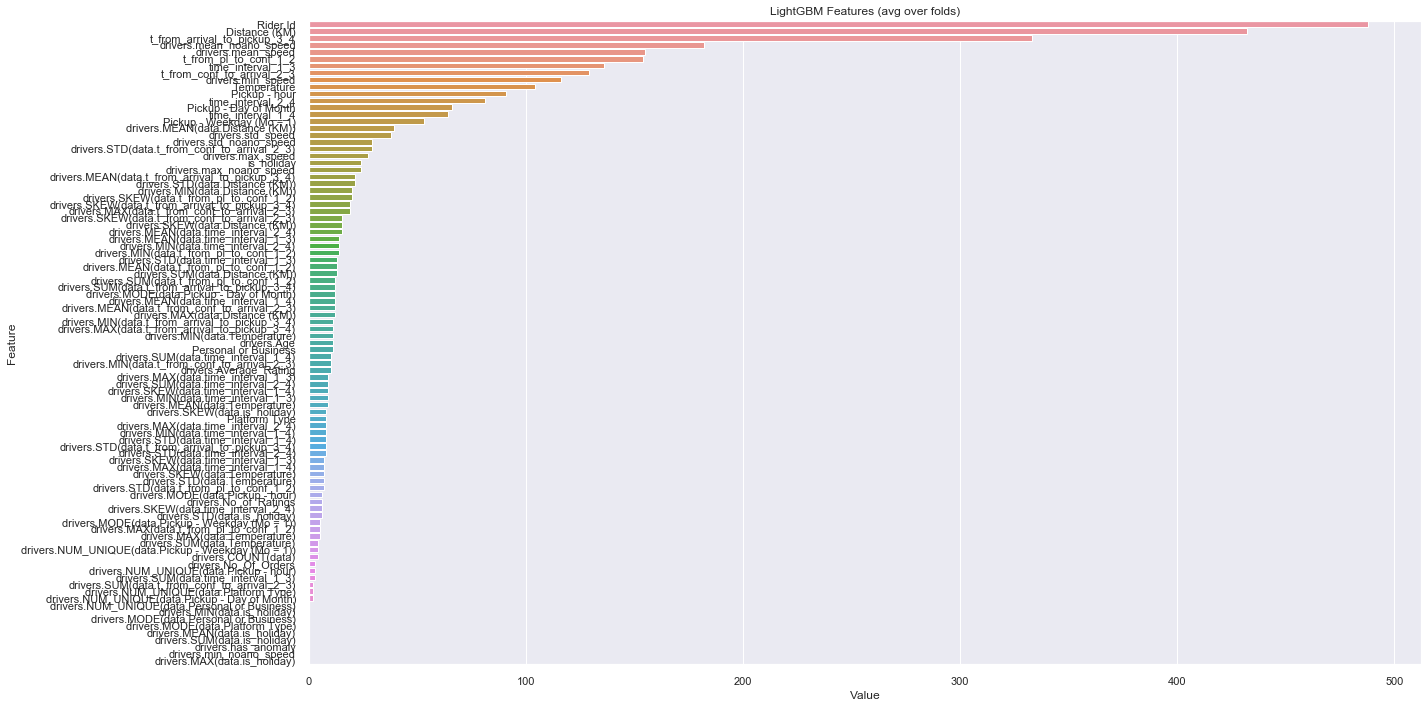

<Figure size 720x432 with 0 Axes>

In [226]:
#Регрессор
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(),X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances-01.png')

In [250]:
#Классификатор
feat_importance = pd.DataFrame()
feat_importance["feature"] = feature_matrix_data_test.columns
feat_importance["value"] = lgb_clf.feature_importances_
feat_importance.sort_values(by='value', ascending=False, inplace=True)

plt.figure(figsize=(24,14))
ax = sns.barplot(y="feature", x="value", data=feat_importance)

ValueError: Length of values does not match length of index

# submission

In [156]:
order_no = feature_matrix_data_test.reset_index()['Order No']
def make_file_submission(predictions,order_no,no):
    df_submission = pd.DataFrame()
    df_submission["Order_No"] = order_no
    df_submission["Time from Pickup to Arrival"] = predictions
    df_submission.to_csv(str(no) + "submission.csv",index=False)

In [238]:
make_file_submission(preds,order_no,'stritified_739.16_')